In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 198)
(631390, 1)
validation
(74368, 198)
(74368, 1)
test
(85358, 198)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 892929 (3.41 MB)


Trainable params: 892929 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:12 - loss: 0.0708 - STD: 7.1549e-05 - MAE: 0.2495

 7/64 [==>...........................] - ETA: 0s - loss: 0.0274 - STD: 4.0496e-05 - MAE: 0.1297  

13/64 [=====>........................] - ETA: 0s - loss: 0.0250 - STD: 2.5253e-05 - MAE: 0.1232

19/64 [=======>......................] - ETA: 0s - loss: 0.0208 - STD: 2.1045e-05 - MAE: 0.1105

25/64 [==========>...................] - ETA: 0s - loss: 0.0187 - STD: 2.0184e-05 - MAE: 0.1065

31/64 [=============>................] - ETA: 0s - loss: 0.0172 - STD: 1.9722e-05 - MAE: 0.1008

37/64 [================>.............] - ETA: 0s - loss: 0.0161 - STD: 2.0067e-05 - MAE: 0.0968

43/64 [===================>..........] - ETA: 0s - loss: 0.0153 - STD: 2.1369e-05 - MAE: 0.0946

49/64 [=====================>........] - ETA: 0s - loss: 0.0146 - STD: 2.2859e-05 - MAE: 0.0928

55/64 [========================>.....] - ETA: 0s - loss: 0.0141 - STD: 2.4352e-05 - MAE: 0.0910

60/64 [===========================>..] - ETA: 0s - loss: 0.0138 - STD: 2.5891e-05 - MAE: 0.0899

64/64 [==============================] - 3s 27ms/step - loss: 0.0136 - STD: 2.7347e-05 - MAE: 0.0892 - val_loss: 0.0095 - val_STD: 4.2134e-05 - val_MAE: 0.0772


Epoch 2/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0097 - STD: 5.0741e-05 - MAE: 0.0782

 7/64 [==>...........................] - ETA: 0s - loss: 0.0099 - STD: 5.2947e-05 - MAE: 0.0780

13/64 [=====>........................] - ETA: 0s - loss: 0.0099 - STD: 5.6118e-05 - MAE: 0.0777

19/64 [=======>......................] - ETA: 0s - loss: 0.0099 - STD: 6.0018e-05 - MAE: 0.0779

25/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 6.3692e-05 - MAE: 0.0779

31/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 6.7499e-05 - MAE: 0.0778

37/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 7.1731e-05 - MAE: 0.0779

43/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 7.6040e-05 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 8.0564e-05 - MAE: 0.0778

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 8.5466e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 9.0501e-05 - MAE: 0.0778

64/64 [==============================] - 1s 11ms/step - loss: 0.0099 - STD: 9.3176e-05 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 1.2588e-04 - val_MAE: 0.0764


Epoch 3/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0102 - STD: 1.5149e-04 - MAE: 0.0787

 6/64 [=>............................] - ETA: 0s - loss: 0.0099 - STD: 1.5940e-04 - MAE: 0.0780

12/64 [====>.........................] - ETA: 0s - loss: 0.0099 - STD: 1.6720e-04 - MAE: 0.0779

18/64 [=======>......................] - ETA: 0s - loss: 0.0099 - STD: 1.7592e-04 - MAE: 0.0779

24/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 1.8549e-04 - MAE: 0.0780

30/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 1.9557e-04 - MAE: 0.0780

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 2.0654e-04 - MAE: 0.0778

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 2.1829e-04 - MAE: 0.0779

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.3197e-04 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.4650e-04 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.6341e-04 - MAE: 0.0779

64/64 [==============================] - 1s 11ms/step - loss: 0.0099 - STD: 2.7543e-04 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 3.9857e-04 - val_MAE: 0.0761


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0097 - STD: 4.7985e-04 - MAE: 0.0775

 7/64 [==>...........................] - ETA: 0s - loss: 0.0099 - STD: 5.1789e-04 - MAE: 0.0778

13/64 [=====>........................] - ETA: 0s - loss: 0.0099 - STD: 5.5506e-04 - MAE: 0.0777

19/64 [=======>......................] - ETA: 0s - loss: 0.0099 - STD: 5.9970e-04 - MAE: 0.0776

25/64 [==========>...................] - ETA: 0s - loss: 0.0098 - STD: 6.5062e-04 - MAE: 0.0777

31/64 [=============>................] - ETA: 0s - loss: 0.0098 - STD: 7.0997e-04 - MAE: 0.0776

37/64 [================>.............] - ETA: 0s - loss: 0.0098 - STD: 7.8170e-04 - MAE: 0.0776

43/64 [===================>..........] - ETA: 0s - loss: 0.0098 - STD: 8.6706e-04 - MAE: 0.0776

49/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 9.6957e-04 - MAE: 0.0775

55/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0775    

61/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0775

64/64 [==============================] - 1s 11ms/step - loss: 0.0098 - STD: 0.0014 - MAE: 0.0774 - val_loss: 0.0090 - val_STD: 0.0030 - val_MAE: 0.0749


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0095 - STD: 0.0036 - MAE: 0.0768

 7/64 [==>...........................] - ETA: 0s - loss: 0.0095 - STD: 0.0042 - MAE: 0.0765

13/64 [=====>........................] - ETA: 0s - loss: 0.0095 - STD: 0.0050 - MAE: 0.0763

19/64 [=======>......................] - ETA: 0s - loss: 0.0094 - STD: 0.0059 - MAE: 0.0760

25/64 [==========>...................] - ETA: 0s - loss: 0.0092 - STD: 0.0073 - MAE: 0.0755

31/64 [=============>................] - ETA: 0s - loss: 0.0091 - STD: 0.0090 - MAE: 0.0749

37/64 [================>.............] - ETA: 0s - loss: 0.0089 - STD: 0.0113 - MAE: 0.0741

43/64 [===================>..........] - ETA: 0s - loss: 0.0087 - STD: 0.0141 - MAE: 0.0732

49/64 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.0174 - MAE: 0.0723

55/64 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0210 - MAE: 0.0713

61/64 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.0243 - MAE: 0.0705

64/64 [==============================] - 1s 11ms/step - loss: 0.0081 - STD: 0.0258 - MAE: 0.0702 - val_loss: 0.0058 - val_STD: 0.0452 - val_MAE: 0.0602


Epoch 6/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0543 - MAE: 0.0628

 7/64 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0537 - MAE: 0.0624

14/64 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0544 - MAE: 0.0623

20/64 [========>.....................] - ETA: 0s - loss: 0.0067 - STD: 0.0552 - MAE: 0.0621

26/64 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0555 - MAE: 0.0620

32/64 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0555 - MAE: 0.0618

38/64 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0556 - MAE: 0.0617

44/64 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0559 - MAE: 0.0617

50/64 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0560 - MAE: 0.0616

56/64 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0561 - MAE: 0.0616

62/64 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0563 - MAE: 0.0615

64/64 [==============================] - 1s 11ms/step - loss: 0.0066 - STD: 0.0563 - MAE: 0.0615 - val_loss: 0.0056 - val_STD: 0.0484 - val_MAE: 0.0579


Epoch 7/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0572 - MAE: 0.0614

 7/64 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0576 - MAE: 0.0607

13/64 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0609

19/64 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0608

25/64 [==========>...................] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0608

30/64 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0608

36/64 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0579 - MAE: 0.0607

42/64 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0581 - MAE: 0.0607

48/64 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0581 - MAE: 0.0606

54/64 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0581 - MAE: 0.0606

60/64 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0581 - MAE: 0.0606

64/64 [==============================] - 1s 11ms/step - loss: 0.0064 - STD: 0.0582 - MAE: 0.0606 - val_loss: 0.0056 - val_STD: 0.0485 - val_MAE: 0.0567


Epoch 8/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0576 - MAE: 0.0591

 7/64 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0579 - MAE: 0.0603

13/64 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0580 - MAE: 0.0602

19/64 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0584 - MAE: 0.0600

25/64 [==========>...................] - ETA: 0s - loss: 0.0063 - STD: 0.0586 - MAE: 0.0601

31/64 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0601

37/64 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0601

43/64 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0601

49/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0601

55/64 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0600

61/64 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0600

64/64 [==============================] - 1s 11ms/step - loss: 0.0063 - STD: 0.0592 - MAE: 0.0600 - val_loss: 0.0054 - val_STD: 0.0503 - val_MAE: 0.0563


Epoch 9/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0593

 7/64 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0601 - MAE: 0.0594

13/64 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0595

19/64 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0595

25/64 [==========>...................] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0594

31/64 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0601 - MAE: 0.0595

37/64 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0602 - MAE: 0.0595

43/64 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0601 - MAE: 0.0595

50/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0596

56/64 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0596

62/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0601 - MAE: 0.0596

64/64 [==============================] - 1s 11ms/step - loss: 0.0062 - STD: 0.0601 - MAE: 0.0596 - val_loss: 0.0053 - val_STD: 0.0508 - val_MAE: 0.0556


Epoch 10/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0581

 7/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0588

13/64 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0591

19/64 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0589

25/64 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0589

31/64 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0590

37/64 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0590

43/64 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0590

49/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0590

55/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0590

61/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0590

64/64 [==============================] - 1s 11ms/step - loss: 0.0061 - STD: 0.0610 - MAE: 0.0590 - val_loss: 0.0052 - val_STD: 0.0523 - val_MAE: 0.0562


Epoch 11/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0593

 7/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0587

13/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0590

19/64 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0610 - MAE: 0.0590

25/64 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0590

31/64 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0590

37/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0589

43/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0589

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0589

55/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0588

61/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0588

64/64 [==============================] - 1s 11ms/step - loss: 0.0060 - STD: 0.0616 - MAE: 0.0587 - val_loss: 0.0051 - val_STD: 0.0524 - val_MAE: 0.0551


Epoch 12/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0584

 7/64 [==>...........................] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0581

13/64 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0580

19/64 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0581

25/64 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0582

31/64 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0582

37/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0581

43/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0581

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0581

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0581

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0581

64/64 [==============================] - 1s 11ms/step - loss: 0.0059 - STD: 0.0625 - MAE: 0.0581 - val_loss: 0.0050 - val_STD: 0.0527 - val_MAE: 0.0544


Epoch 13/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0569

 7/64 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0631 - MAE: 0.0574

13/64 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0577

19/64 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0580

26/64 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0583

32/64 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0584

38/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0584

44/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0584

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0583

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0582

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0582

64/64 [==============================] - 1s 11ms/step - loss: 0.0059 - STD: 0.0624 - MAE: 0.0582 - val_loss: 0.0049 - val_STD: 0.0544 - val_MAE: 0.0544


Epoch 14/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0058 - STD: 0.0651 - MAE: 0.0579

 7/64 [==>...........................] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0576

13/64 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0574

19/64 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0573

25/64 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0573

31/64 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0573

37/64 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0572

43/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0573

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0573

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0573

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0573

64/64 [==============================] - 1s 11ms/step - loss: 0.0057 - STD: 0.0638 - MAE: 0.0573 - val_loss: 0.0049 - val_STD: 0.0536 - val_MAE: 0.0535


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0640 - MAE: 0.0567

 7/64 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0569

13/64 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0569

19/64 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0570

25/64 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0571

31/64 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0572

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0574

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0577

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0578

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0578

61/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0577

64/64 [==============================] - 1s 11ms/step - loss: 0.0058 - STD: 0.0632 - MAE: 0.0577 - val_loss: 0.0050 - val_STD: 0.0530 - val_MAE: 0.0534


Epoch 16/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0637 - MAE: 0.0571

 7/64 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0649 - MAE: 0.0568

13/64 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0569

19/64 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0569

25/64 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0569

31/64 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0568

37/64 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0568

44/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0568

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0568

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0568

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0568

64/64 [==============================] - 1s 11ms/step - loss: 0.0057 - STD: 0.0646 - MAE: 0.0568 - val_loss: 0.0048 - val_STD: 0.0542 - val_MAE: 0.0534


Epoch 17/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0564

 7/64 [==>...........................] - ETA: 0s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0566

13/64 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0568

19/64 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0568

25/64 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0567

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0567

37/64 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0566

43/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0567

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0567

55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0567

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0567

64/64 [==============================] - 1s 11ms/step - loss: 0.0056 - STD: 0.0647 - MAE: 0.0568 - val_loss: 0.0049 - val_STD: 0.0535 - val_MAE: 0.0530


Epoch 18/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0637 - MAE: 0.0560

 7/64 [==>...........................] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0567

13/64 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0566

19/64 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0565

25/64 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0565

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0566

37/64 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0566

43/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0566

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0565

55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0565

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0565

64/64 [==============================] - 1s 11ms/step - loss: 0.0056 - STD: 0.0652 - MAE: 0.0565 - val_loss: 0.0049 - val_STD: 0.0531 - val_MAE: 0.0529


Epoch 19/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0558

 7/64 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0567

13/64 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0565

19/64 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0565

25/64 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0566

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0565

37/64 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0565

43/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0565

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0565

55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0565

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0566

64/64 [==============================] - 1s 10ms/step - loss: 0.0056 - STD: 0.0651 - MAE: 0.0567 - val_loss: 0.0055 - val_STD: 0.0483 - val_MAE: 0.0544


Epoch 20/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0572 - MAE: 0.0571

 7/64 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0609 - MAE: 0.0601

13/64 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0594

19/64 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0599 - MAE: 0.0588

25/64 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0582

31/64 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0620 - MAE: 0.0579

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0625 - MAE: 0.0577

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0576

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0574

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0634 - MAE: 0.0573

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0572

64/64 [==============================] - 1s 11ms/step - loss: 0.0057 - STD: 0.0635 - MAE: 0.0572 - val_loss: 0.0049 - val_STD: 0.0572 - val_MAE: 0.0553


Epoch 21/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0690 - MAE: 0.0587

 7/64 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0566

13/64 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0566

19/64 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0567

25/64 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0567

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0566

37/64 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0566

43/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0565

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0565

55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0564

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0565

64/64 [==============================] - 1s 11ms/step - loss: 0.0056 - STD: 0.0648 - MAE: 0.0565 - val_loss: 0.0048 - val_STD: 0.0534 - val_MAE: 0.0528


Epoch 22/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0560

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0558

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0559

19/64 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0558

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0560

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0561

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0561

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0562

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0562

55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0562

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0562

64/64 [==============================] - 1s 11ms/step - loss: 0.0056 - STD: 0.0654 - MAE: 0.0562 - val_loss: 0.0049 - val_STD: 0.0530 - val_MAE: 0.0527


Epoch 23/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0552

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0560

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0560

19/64 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0650 - MAE: 0.0561

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0561

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0562

37/64 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0562

43/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0562

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0562

55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0562

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0562

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0654 - MAE: 0.0561 - val_loss: 0.0048 - val_STD: 0.0541 - val_MAE: 0.0526


Epoch 24/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0643 - MAE: 0.0555

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0559

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0559

18/64 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0559

24/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0559

30/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0558

36/64 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0559

42/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0560

48/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0560

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0560

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0560

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0657 - MAE: 0.0560 - val_loss: 0.0049 - val_STD: 0.0527 - val_MAE: 0.0526


Epoch 25/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0631 - MAE: 0.0561

 7/64 [==>...........................] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0562

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0561

19/64 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0560

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0560

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0560

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0560

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0560

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0560

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0561

61/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0561

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0654 - MAE: 0.0561 - val_loss: 0.0048 - val_STD: 0.0541 - val_MAE: 0.0525


Epoch 26/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0554

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0559

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0560

19/64 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0558

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0557

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0558

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0557

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0558

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0558

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0558

61/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0558

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0660 - MAE: 0.0558 - val_loss: 0.0048 - val_STD: 0.0560 - val_MAE: 0.0525


Epoch 27/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0549

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0668 - MAE: 0.0558

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0559

19/64 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0558

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0558

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0558

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0558

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0558

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0557

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0557

61/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0557

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0662 - MAE: 0.0557 - val_loss: 0.0048 - val_STD: 0.0553 - val_MAE: 0.0527


Epoch 28/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0662 - MAE: 0.0562

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0558

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0556

19/64 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0556

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0557

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0556

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0557

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0557

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0557

61/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0557

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0661 - MAE: 0.0557 - val_loss: 0.0047 - val_STD: 0.0568 - val_MAE: 0.0530


Epoch 29/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0676 - MAE: 0.0564

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0557

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0559

19/64 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0559

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0558

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0558

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0557

42/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0556

48/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0556

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0556

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0556

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0662 - MAE: 0.0557 - val_loss: 0.0048 - val_STD: 0.0541 - val_MAE: 0.0524


Epoch 30/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0553

 7/64 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0553

13/64 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0554

19/64 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0555

26/64 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0555

32/64 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0556

38/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0556

44/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0556

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0556

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0556

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0556

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0661 - MAE: 0.0557 - val_loss: 0.0050 - val_STD: 0.0507 - val_MAE: 0.0526


Epoch 31/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0604 - MAE: 0.0566

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0559

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0559

19/64 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0558

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0557

36/64 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0557

42/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0556

48/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0556

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0556

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0556

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0661 - MAE: 0.0556 - val_loss: 0.0049 - val_STD: 0.0538 - val_MAE: 0.0523


Epoch 32/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0545

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0555

13/64 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0553

19/64 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0554

25/64 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0553

31/64 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0554

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0555

44/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0555

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0555

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0555

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0555

64/64 [==============================] - 1s 10ms/step - loss: 0.0055 - STD: 0.0662 - MAE: 0.0555 - val_loss: 0.0048 - val_STD: 0.0551 - val_MAE: 0.0524


Epoch 33/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0542

 7/64 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0554

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0557

19/64 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0557

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0556

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0555

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0556

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0555

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0555

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0555

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0554

64/64 [==============================] - 1s 10ms/step - loss: 0.0054 - STD: 0.0665 - MAE: 0.0554 - val_loss: 0.0048 - val_STD: 0.0531 - val_MAE: 0.0524


Epoch 34/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0558

 7/64 [==>...........................] - ETA: 0s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0552

13/64 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0554

19/64 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0554

25/64 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0555

38/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0554

44/64 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0554

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0554

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0553

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0553

64/64 [==============================] - 1s 10ms/step - loss: 0.0054 - STD: 0.0664 - MAE: 0.0553 - val_loss: 0.0047 - val_STD: 0.0575 - val_MAE: 0.0529


Epoch 35/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0693 - MAE: 0.0557

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0667 - MAE: 0.0556

13/64 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0667 - MAE: 0.0554

19/64 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0553

25/64 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0553

31/64 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0552

37/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0553

43/64 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0552

49/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0553

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0554

61/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0555

64/64 [==============================] - 1s 10ms/step - loss: 0.0055 - STD: 0.0663 - MAE: 0.0554 - val_loss: 0.0048 - val_STD: 0.0544 - val_MAE: 0.0520


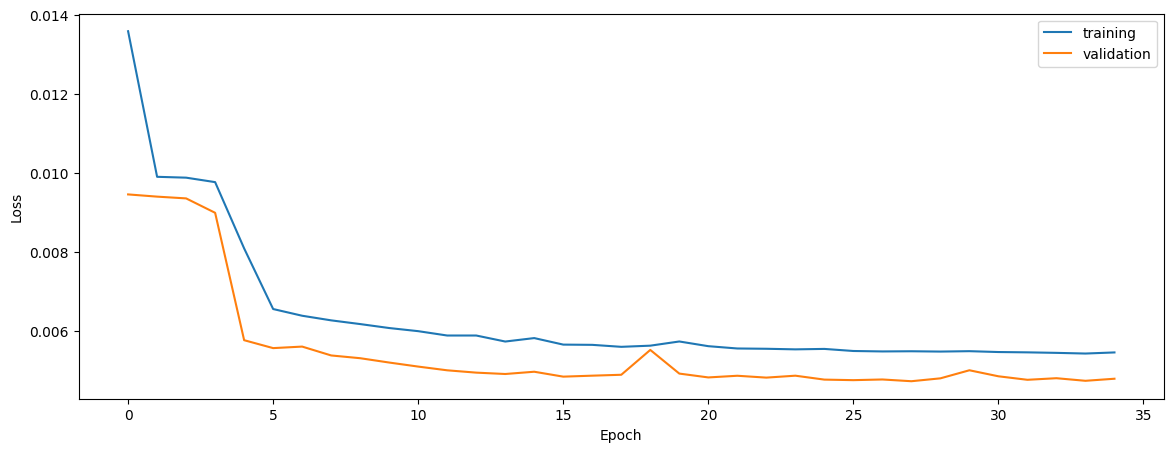

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.6708361481717957
0.7057481866067875
0.6464059649334136


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.6708361481717957
0.7057481866067875
0.6464059649334136


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.6727676851585669
0.7051393403105379
0.6599722703922686


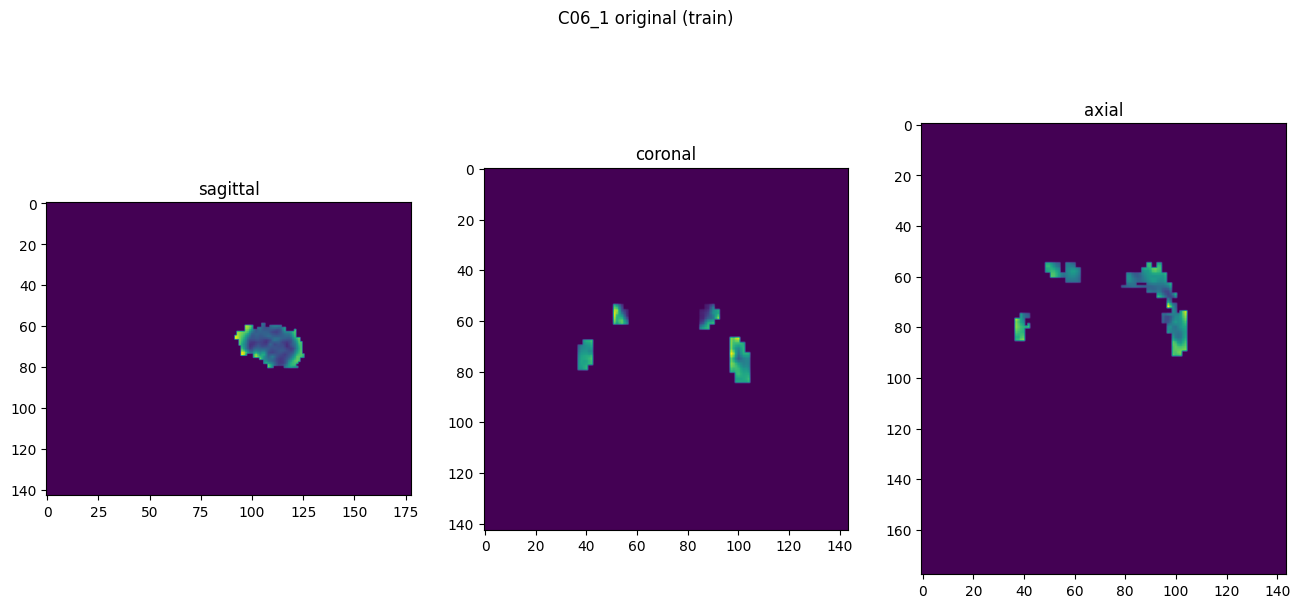

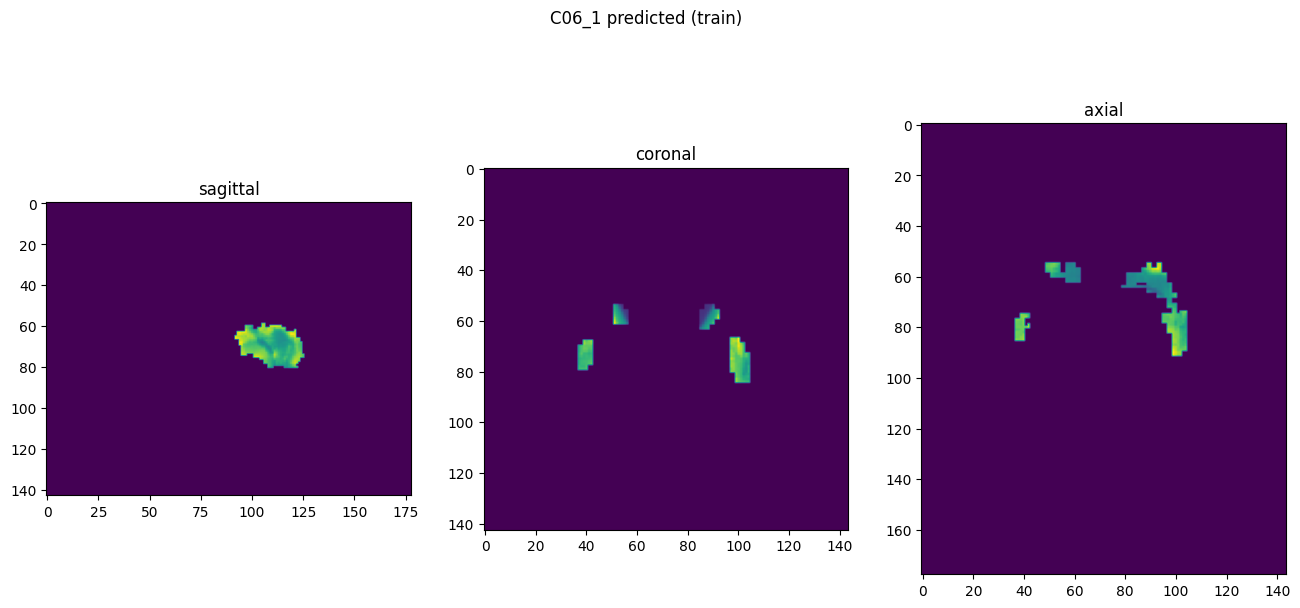

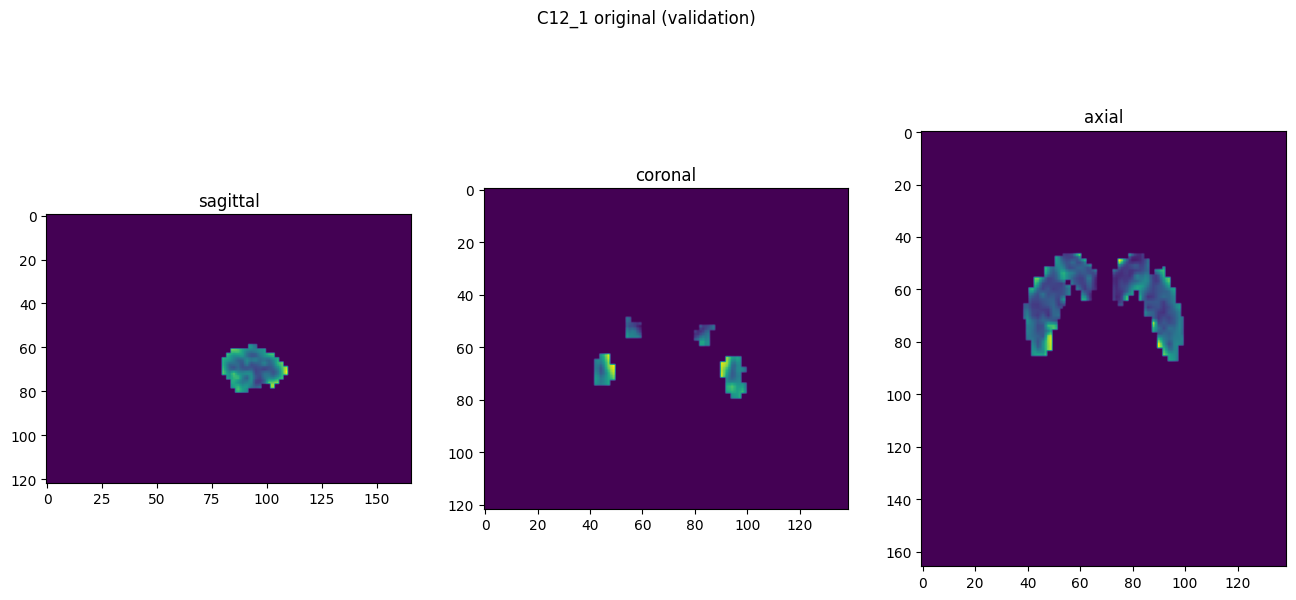

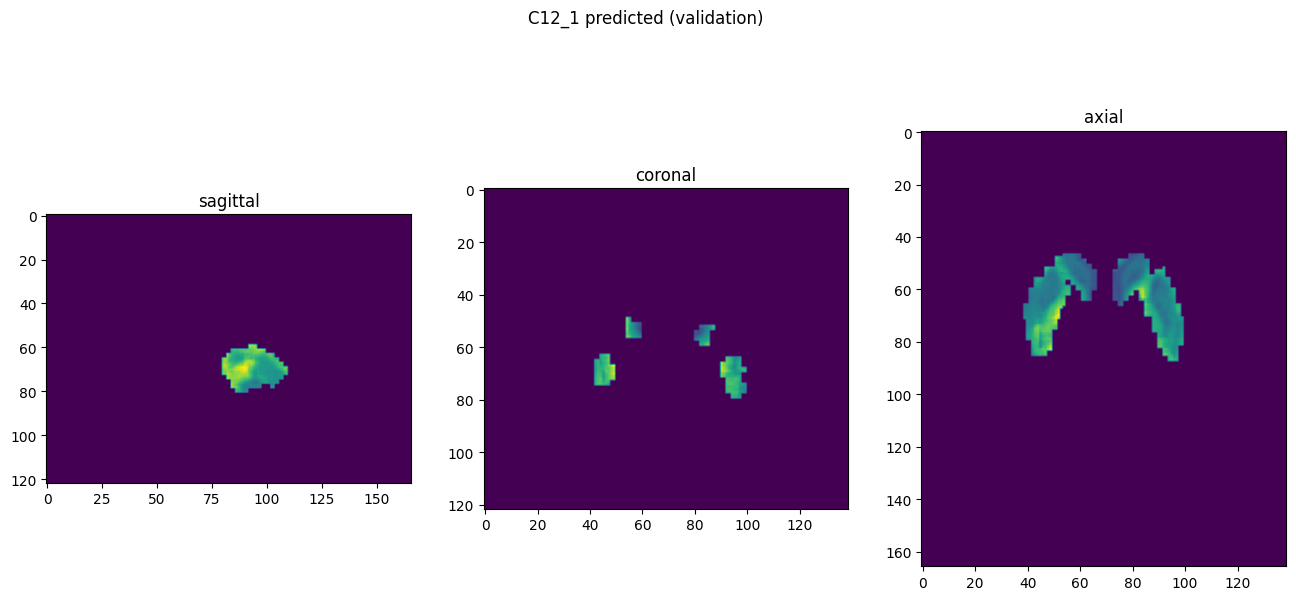

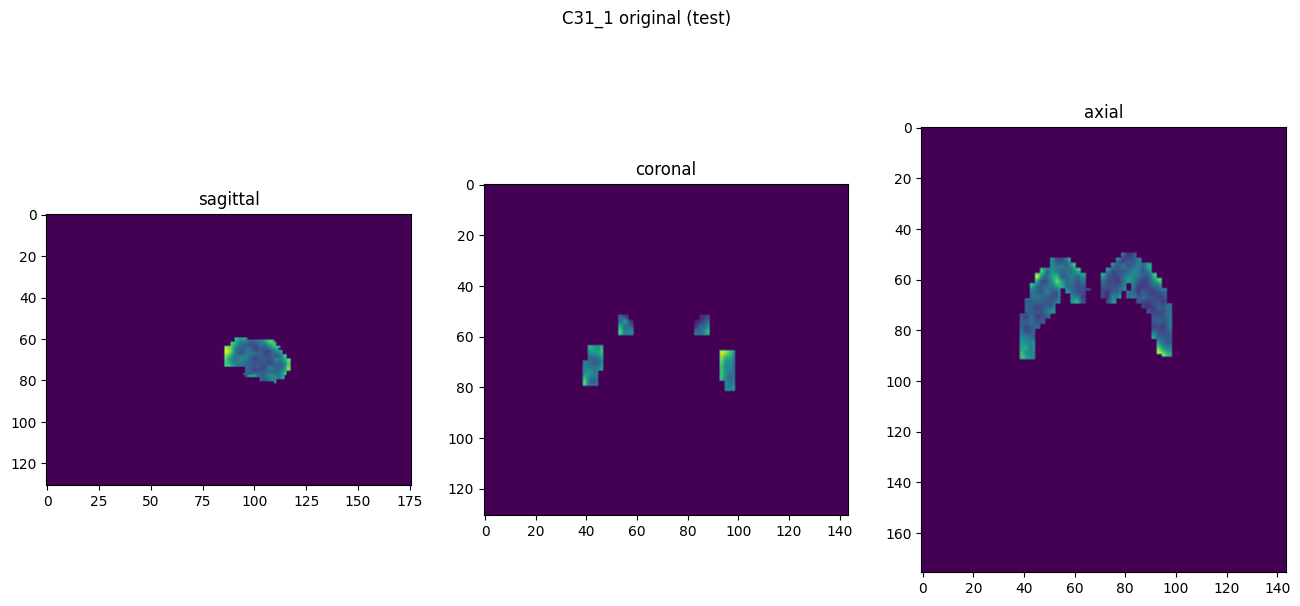

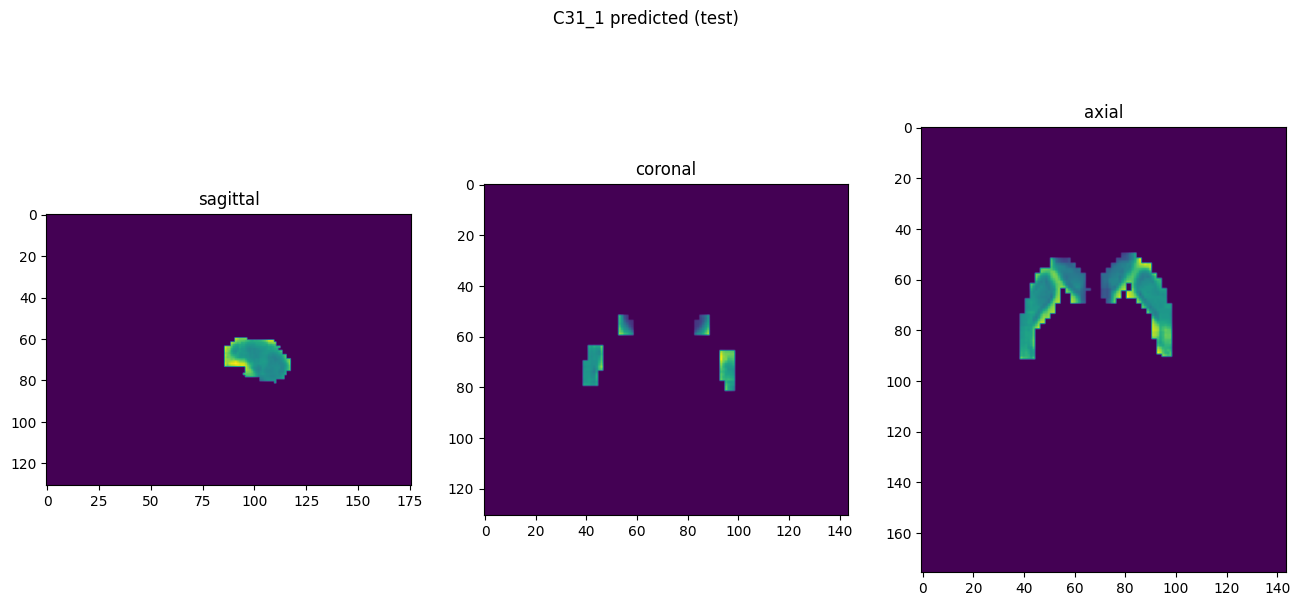

In [10]:
showResults(model, gen, threshold=None, background=False)